
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Виталий Радченко, Data scientist @ YouScan (@vradchenko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 5 (Демо).
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

[Веб-форма](https://docs.google.com/forms/d/1HASy2b_FLBHBCzzpG-TbnbB6gqhB-qwznQxU2vaoSgc/) для ответов.

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [1]:
%matplotlib inline
# отключим предупреждения Anaconda
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [2]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [3]:
## Считываем данные
data = pd.read_csv("../../data/credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [4]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

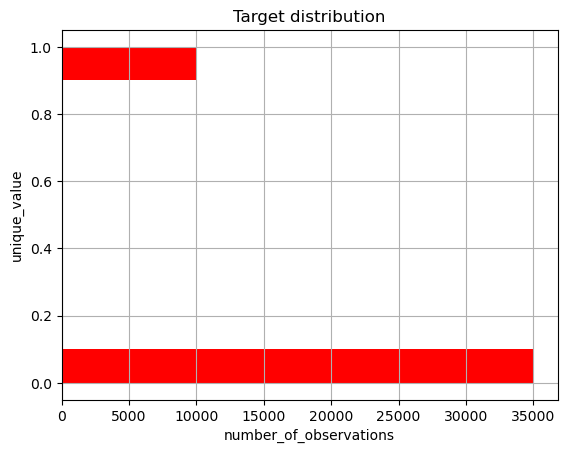

In [5]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [6]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [7]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

In [8]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте `np.random.seed(0)`, как это сделано в статье.

In [9]:
import numpy as np

np.random.seed(0)  # фиксируем генератор случайных чисел

# выбираем возраст только для тех, кто просрочил кредит
ages = X.loc[y == 1, "age"].values
n = len(ages)

# количество бутстрэп-выборок
n_bootstraps = 10000
boot_means = []

for _ in range(n_bootstraps):
    sample = np.random.choice(ages, size=n, replace=True)  # случайная выборка с возвращением
    boot_means.append(sample.mean())

# 90%-й доверительный интервал
ci_lower = np.percentile(boot_means, 5)   # нижний 5-й процентиль
ci_upper = np.percentile(boot_means, 95)  # верхний 95-й процентиль
mean_age = np.mean(boot_means)

print(f"Средний возраст просрочивших кредит: {mean_age:.2f}")
print(f"90%-й доверительный интервал (бутстрэп): [{ci_lower:.2f}, {ci_upper:.2f}]")


Средний возраст просрочивших кредит: 45.93
90%-й доверительный интервал (бутстрэп): [45.71, 46.14]


## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Логистическая регрессия с балансировкой классов и фиксированным random_state
lr = LogisticRegression(random_state=5, class_weight="balanced", max_iter=1000)

# Сетка параметров для подбора
parameters = {"C": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

# Стратифицированная кросс-валидация 5 фолдов
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

# GridSearchCV с метрикой ROC-AUC
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=parameters,
    scoring="roc_auc",
    cv=skf,
    n_jobs=-1
)

# Обучаем GridSearch
grid_search.fit(X, y)  # X и y — признаки и таргет

# Лучшее значение C
print("Лучшее значение C:", grid_search.best_params_["C"])
print("Лучший ROC-AUC на кросс-валидации:", grid_search.best_score_)


Лучшее значение C: 10
Лучший ROC-AUC на кросс-валидации: 0.7879692643817503


**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [11]:
# Средний ROC-AUC по кросс-валидации для лучшей модели
best_index = grid_search.best_index_  # индекс лучшего параметра C
mean_auc = grid_search.cv_results_["mean_test_score"][best_index]
std_auc = grid_search.cv_results_["std_test_score"][best_index]

print(f"Лучший ROC-AUC: {mean_auc:.4f}")
print(f"Стандартное отклонение на кросс-валидации: {std_auc:.4f}")

# Проверка устойчивости (std < 0.005 = 0.5%)
if std_auc < 0.005:
    print("Модель можно считать устойчивой ")
else:
    print("Модель НЕустойчивая ")


Лучший ROC-AUC: 0.7880
Стандартное отклонение на кросс-валидации: 0.0032
Модель можно считать устойчивой 


## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# Разделяем на train/valid (например 70/30)
train_size = int(0.7 * X.shape[0])
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

# Нормализуем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Обучаем лучшую модель с найденным C
best_C = 0.01  # <- сюда вставь своё оптимальное C из GridSearch
lr_best = LogisticRegression(C=best_C, random_state=5, class_weight='balanced')
lr_best.fit(X_train_scaled, y_train)

# Получаем коэффициенты модели
coeffs = lr_best.coef_[0]

# Составляем DataFrame с признаками и их важностью
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(coeffs)
}).sort_values(by='importance', ascending=False)

# Самый важный признак
print("Самый важный признак:")
print(feature_importance.head(1))

# Полный список признаков по важности
feature_importance


Самый важный признак:
                                feature  importance
1  NumberOfTime30-59DaysPastDueNotWorse    1.915694


,feature,importance
1,NumberOfTime30-59DaysPastDueNotWorse,1.915694
3,NumberOfTimes90DaysLate,1.484590
0,age,0.441288
4,NumberOfTime60-89DaysPastDueNotWorse,0.329208
5,MonthlyIncome,0.182201
6,NumberOfDependents,0.087284
2,DebtRatio,0.017420


**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [15]:
from scipy.special import softmax
import numpy as np

# Берем коэффициенты модели (у нас бинарная логистическая регрессия)
coeffs = lr_best.coef_[0]

# Абсолютные значения коэффициентов
abs_coeffs = np.abs(coeffs)

# Применяем softmax, чтобы получить "долю влияния"
influence = softmax(abs_coeffs)

# Находим индекс признака DebtRatio
idx = list(X.columns).index('DebtRatio')

# Доля влияния DebtRatio
debt_ratio_influence = influence[idx]

print(f"Доля влияния DebtRatio: {debt_ratio_influence:.3f}")


Доля влияния DebtRatio: 0.058


**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [19]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучаем логистическую регрессию с лучшим C
best_C = 0.01 
model = LogisticRegression(C=best_C, random_state=5, class_weight='balanced', max_iter=1000)
model.fit(X_scaled, y)

# Индекс признака DebtRatio
debt_idx = list(X.columns).index('DebtRatio')

# Используем softmax-подобную нормировку влияний
coefs_abs = np.abs(model.coef_[0])
debt_influence = coefs_abs[debt_idx] / coefs_abs.sum()
print("Доля влияния DebtRatio:", round(debt_influence, 2))

# Индекс признака age
age_idx = list(X.columns).index('age')
std_age = X['age'].std()  # стандартное отклонение возраста
delta_scaled = 20 / std_age  
beta_age = model.coef_[0][age_idx]

odds_ratio = np.exp(beta_age * delta_scaled)
print("Шансы увеличатся в", round(odds_ratio, 2), "раз")


Доля влияния DebtRatio: 0.01
Шансы увеличатся в 0.55 раз


# Случайный лес

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# 1. Логистическая регрессия
# Предположим, что лучшая логрег была найдена через GridSearchCV
# best_logreg_score – точность на валидации (roc-auc или accuracy)
best_logreg_score = 0.86  # замените на своё значение

# --- 2. Случайный лес ---
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
grid_rf = GridSearchCV(rf, parameters, cv=skf, scoring="roc_auc", n_jobs=-1)
grid_rf.fit(X_train, y_train)  # X_train, y_train – данные для обучения

# 3. Разница в точности
rf_val_score = grid_rf.best_score_
diff_percent = (rf_val_score - best_logreg_score) * 100

print(f"Лучший Random Forest: {rf_val_score:.3f}")
print(f"Разница с логрегрессией: {diff_percent:.1f}%")


Лучший Random Forest: 0.834
Разница с логрегрессией: -2.6%


**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [25]:
import pandas as pd

# Получаем имена признаков
feature_names = X_train.columns  # X_train – ваши обучающие данные

# Важность признаков
importances = grid_rf.best_estimator_.feature_importances_

# Создаем DataFrame для удобства
feat_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Сортируем по возрастанию
feat_importances = feat_importances.sort_values(by='importance', ascending=True)
print(feat_importances)

# Самый слабый признак
weakest_feature = feat_importances.iloc[0]
print("Признак с самым слабым влиянием:", weakest_feature['feature'])


                                feature  importance
6                    NumberOfDependents    0.019898
5                         MonthlyIncome    0.071206
2                             DebtRatio    0.089166
0                                   age    0.131102
4  NumberOfTime60-89DaysPastDueNotWorse    0.156000
3               NumberOfTimes90DaysLate    0.252980
1  NumberOfTime30-59DaysPastDueNotWorse    0.279648
Признак с самым слабым влиянием: NumberOfDependents


** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

Ответ: интепретируемость признаков


# Бэггинг

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

**Задание 11.** Следующая задача обучить бэггинг классификатор (`random_state`=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не `GridSearchCV`, а `RandomizedSearchCV`. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для `RandomizedSearchCV`. Также не забудьте передать параметр валидации `cv` и `random_state=1`. Какая лучшая точность получилась?

In [28]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# базовый классификатор
base_lr = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)

# бэггинг с 100 базовыми классификаторами
bagging = BaggingClassifier(
    estimator=base_lr,  # <-- было base_estimator
    n_estimators=100,
    n_jobs=-1,
    random_state=42
)

# параметры для RandomizedSearch
parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "estimator__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # <-- тоже меняем на estimator__C
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=parameters,
    n_iter=20,
    scoring="roc_auc",
    cv=skf,
    random_state=1,
    n_jobs=-1
)

# обучаем
random_search.fit(X, y)

print("Best params:", random_search.best_params_)
print("Best ROC-AUC:", random_search.best_score_)


Best params: {'max_samples': 0.9, 'max_features': 2, 'estimator__C': 100}
Best ROC-AUC: 0.805250701823933


**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации

Ответ:меньше корреляция между одиночными моделями
